In [16]:
from statsbombpy import sb
import pandas as pd
import matplotlib.pyplot as plt


In [17]:
competitions = sb.competitions()

/Users/mpr/anaconda3/envs/BDEProject/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


In [18]:
matches = sb.matches(competition_id=9, season_id=281).truncate(after=-1)

for index, competition in competitions.iterrows():
    if (competition["competition_gender"] != 'male' or 
        competition["competition_international"] == True or
        competition["competition_youth"] == True
        ):
        continue
    matches = pd.concat([matches,sb.matches(competition_id=competition["competition_id"], season_id= competition["season_id"])])

matches.drop(["match_status_360","last_updated","last_updated_360","match_status","data_version","shot_fidelity_version","xy_fidelity_version"],axis=1, inplace=True)
matches['match_date'] = pd.to_datetime(matches['match_date'])
matches = matches.sort_values('match_date')

/Users/mpr/anaconda3/envs/BDEProject/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/mpr/anaconda3/envs/BDEProject/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/mpr/anaconda3/envs/BDEProject/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/mpr/anaconda3/envs/BDEProject/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/mpr/anaconda3/envs/BDEProject/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/mpr/anaconda3/envs/BDEProject/lib/python3.12/site-packages/statsbombpy/api_client.py:21:

In [19]:
team_stats = pd.DataFrame()
# Initialize team_stats
team_stats = pd.DataFrame({
    'team': pd.concat([matches['home_team'], matches['away_team']]).unique(),
    'elo_rating': 1500,
    'total_games': 0,
    'total_wins': 0,
    'total_draws': 0,
    'total_lost': 0,
    'total_goals_scored': 0,
    'total_goals_conceded': 0,
}).set_index('team')

# Iterate over each match and update team_stats
for _, match in matches.iterrows():
    home_team = match['home_team']
    away_team = match['away_team']
    home_score = match['home_score']
    away_score = match['away_score']

    # Update wins/draws/losses
    if home_score > away_score:
        team_stats.loc[home_team, 'total_wins'] += 1
        team_stats.loc[away_team, 'total_lost'] += 1
    elif home_score < away_score:
        team_stats.loc[away_team, 'total_wins'] += 1
        team_stats.loc[home_team, 'total_lost'] += 1
    else:  # Draw
        team_stats.loc[home_team, 'total_draws'] += 1
        team_stats.loc[away_team, 'total_draws'] += 1
    
    # Update home team stats
    team_stats.loc[home_team, 'total_games'] += 1
    team_stats.loc[home_team, 'total_goals_scored'] += home_score
    team_stats.loc[home_team, 'total_goals_conceded'] += away_score
    
    # Update away team stats
    team_stats.loc[away_team, 'total_games'] += 1
    team_stats.loc[away_team, 'total_goals_scored'] += away_score
    team_stats.loc[away_team, 'total_goals_conceded'] += home_score

# Reset index for cleaner output
team_stats = team_stats.reset_index()
team_stats

,team,elo_rating,total_games,total_wins,total_draws,total_lost,total_goals_scored,total_goals_conceded
0,Ajax,1500,3,3,0,0,5,0
1,Real Madrid,1500,71,39,13,19,162,97
2,NY Cosmos,1500,1,1,0,0,2,1
3,Barcelona,1500,532,393,86,53,1409,444
4,Argentina U20,1500,1,1,0,0,3,1
...,...,...,...,...,...,...,...,...
162,FC Porto,1500,1,1,0,0,3,0
163,Metz,1500,1,0,0,1,0,5
164,Nashville SC,1500,1,0,1,0,0,0
165,Toronto FC,1500,1,0,0,1,0,4


In [20]:
# ELO parameters
K_FACTOR = 30
HOME_ADVANTAGE = 100

elo_history = []


elo_ratings = pd.Series(1500, index=team_stats['team'], name='elo_rating')


for idx, match in matches.iterrows():
    home_team = match['home_team']
    away_team = match['away_team']
    home_score = match['home_score']
    away_score = match['away_score']
    
    # Get current ratings with home advantage
    home_elo = elo_ratings[home_team] + HOME_ADVANTAGE
    away_elo = elo_ratings[away_team]
    
    # Calculate expected outcome (logistic function)
    expected_home = 1 / (1 + 10**((away_elo - home_elo)/400))
    expected_away = 1 - expected_home
    
    # Determine actual outcome
    if home_score > away_score:
        actual_home = 1
        actual_away = 0
    elif home_score < away_score:
        actual_home = 0
        actual_away = 1
    else:
        actual_home = 0.5
        actual_away = 0.5
    
    # Update ratings
    elo_ratings[home_team] += K_FACTOR * (actual_home - expected_home)
    elo_ratings[away_team] += K_FACTOR * (actual_away - expected_away)
    
    # Store historical ratings
    elo_history.append({
        'date': match['match_date'],
        'team': home_team,
        'elo': elo_ratings[home_team] - HOME_ADVANTAGE,  # Remove HA for storage
        'match_id': idx
    })
    elo_history.append({
        'date': match['match_date'],
        'team': away_team,
        'elo': elo_ratings[away_team],
        'match_id': idx
    })

# Convert history to DataFrame
elo_history_df = pd.DataFrame(elo_history)

# Merge final ratings with team_stats
team_stats['elo_rating'] = team_stats['team'].map(elo_ratings)

/var/folders/_g/cgqqm2t50r996d6p3mf_b4_c0000gn/T/ipykernel_5614/2065549664.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1510.7980500059134' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  elo_ratings[home_team] += K_FACTOR * (actual_home - expected_home)


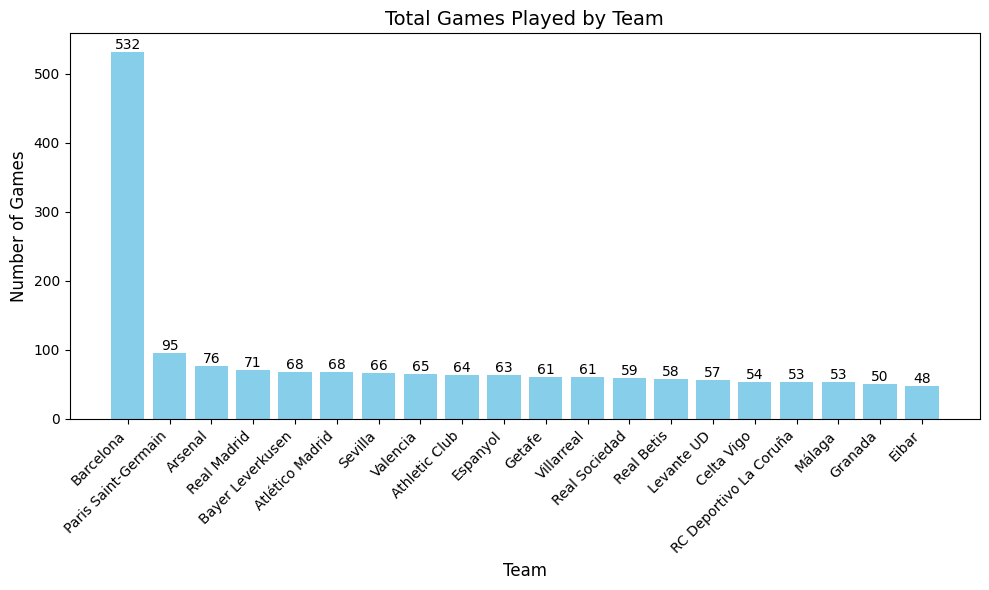

In [21]:
# 1. Sort team_stats by total_games (descending)
team_stats_sorted = team_stats.sort_values('total_games', ascending=False).head(20)

plt.figure(figsize=(10, 6))
bars = plt.bar(
    team_stats_sorted['team'],
    team_stats_sorted['total_games'],
    color='skyblue'
)

# 3. Customize the plot
plt.title('Total Games Played by Team', fontsize=14)
plt.xlabel('Team', fontsize=12)
plt.ylabel('Number of Games', fontsize=12)
plt.xticks(rotation=45, ha='right')

# 4. Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2.,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom'
    )

plt.tight_layout()  # Prevent label cutoff
plt.show()

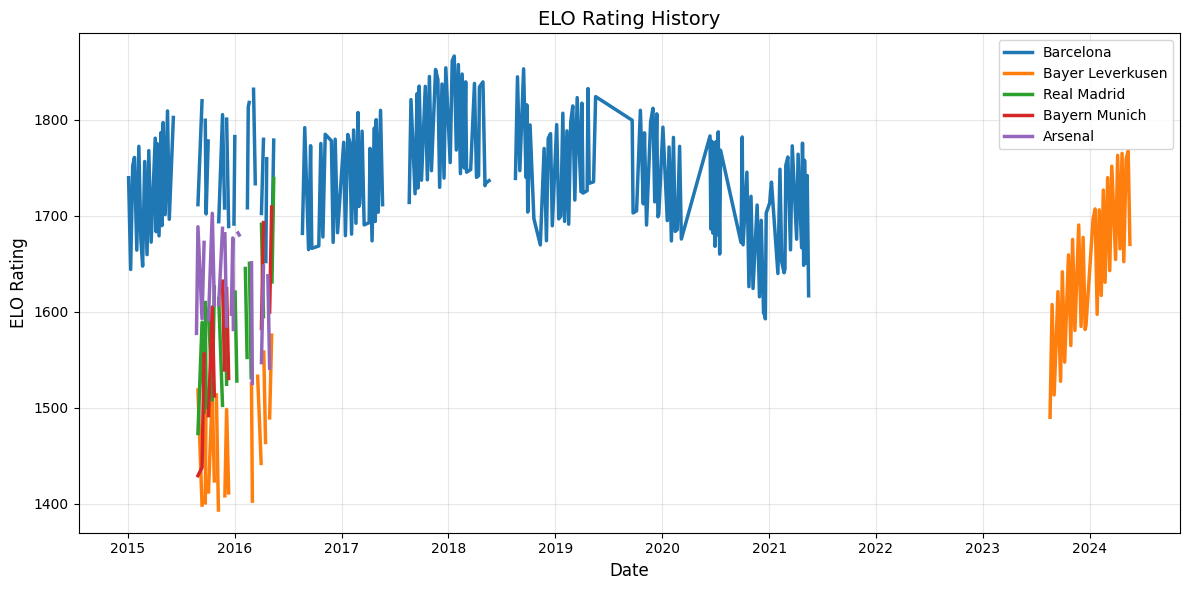

In [22]:
selected_teams = ['Barcelona', 'Bayer Leverkusen', 'Real Madrid', 'Bayern Munich', 'Arsenal']
team_history = elo_history_df[elo_history_df['team'].isin(selected_teams)]
team_history = team_history[team_history['date'] > '2014-12-31']

# 2. Pivot for clean plotting
elo_pivot = team_history.pivot(index='date', columns='team', values='elo')

# 3. Create the plot
plt.figure(figsize=(12, 6))
for team in selected_teams:
    plt.plot(elo_pivot.index, elo_pivot[team], label=team, linewidth=2.5)

# 4. Customize
plt.title('ELO Rating History', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('ELO Rating', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()